In [2]:
import io
import os
import platform
import pdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pyplot import cm

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

In [3]:
data=pd.read_csv('toronto.csv')
data.replace(9999,np.nan,inplace=True)
data.replace(-999,np.nan,inplace=True)
for i in range(len(data)):
    for j in range(len(data.columns)):
        if np.isnan(data.iat[i,j]):
            if i==0:
                data.iloc[i,j]=data.iat[i+1,j]
            elif i==len(data)-1:
                data.iloc[i,j]=data.iat[i-1,j]
            else:
                data.iloc[i,j]=np.nanmean([data.iat[i-1,j],data.iat[i+1,j]])

In [4]:
# data.fillna(np.mean(data),inplace=True)

In [5]:
data.head()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Wind Chill,NO,NO2,NOx,O3,PM25
0,-6.2,-13.2,58.0,25.0,43.0,16.1,100.68,-16.0,3.0,15.0,18.0,19.0,6.0
1,-6.0,-13.7,55.0,24.0,41.0,16.1,100.59,-16.0,2.0,14.0,16.0,19.0,7.0
2,-6.2,-13.3,57.0,24.0,45.0,16.1,100.56,-16.0,1.0,10.0,11.0,22.0,7.0
3,-6.0,-12.0,63.0,24.0,32.0,16.1,100.58,-15.0,1.0,10.0,11.0,21.0,7.0
4,-6.0,-12.2,62.0,24.0,35.0,16.1,100.50,-15.0,2.0,11.0,13.0,19.0,7.0


In [6]:
dataset=pd.DataFrame(data,columns=data.columns[:])
split=round(0.90*len(dataset))
data1=dataset.iloc[:split].copy()
test_set=dataset.iloc[split:].copy()

In [7]:
scaler = preprocessing.MinMaxScaler() 
data1 = scaler.fit_transform(data1)
test_set1=scaler.transform(test_set)
# dataset.loc[:,:] = scaled_values

In [8]:
test_set

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Wind Chill,NO,NO2,NOx,O3,PM25
7884,7.1,1.0,65.0,12.0,9.0,16.1,102.57,-6.0,11.0,21.0,32.0,14.0,11.0
7885,7.4,1.3,65.0,11.0,13.0,16.1,102.49,-6.0,6.0,16.0,22.0,19.0,10.0
7886,7.4,1.1,64.0,10.0,13.0,16.1,102.44,-6.0,5.0,16.0,21.0,19.0,11.0
7887,7.4,1.9,68.0,8.0,15.0,16.1,102.38,-6.0,2.0,13.0,15.0,25.0,10.0
7888,7.0,2.5,73.0,8.0,17.0,16.1,102.32,-6.0,3.0,19.0,23.0,16.0,12.0
7889,6.2,3.2,81.0,6.0,18.0,16.1,102.31,-6.0,2.0,19.0,20.0,18.0,12.0
7890,6.1,3.9,86.0,7.0,15.0,16.1,102.30,-6.0,2.0,20.0,22.0,16.0,12.0
7891,6.8,4.0,82.0,6.0,17.0,16.1,102.31,-6.0,3.0,23.0,25.0,14.0,12.0
7892,6.4,4.2,86.0,7.0,15.0,16.1,102.26,-6.0,2.0,21.0,23.0,15.0,12.0
7893,6.5,3.8,83.0,7.0,15.0,16.1,102.23,-6.0,3.0,22.0,25.0,15.0,10.0


In [12]:
# data_set=np.asarray(dataset,dtype=np.float32)
seq_len=30 + 5
x=len(data1)-seq_len
y=len(test_set)-seq_len
sequences = [np.asarray(data1[t:t+seq_len]) for t in range(x)]
test_seq=[np.asarray(test_set[t:t+seq_len]) for t in range(y)]
test_seq1=[np.asarray(test_set1[t:t+seq_len]) for t in range(y)]

In [13]:
type(test_seq)

list

In [17]:
seq=torch.FloatTensor(np.asarray(sequences))
test_seq=torch.FloatTensor(np.asarray(test_seq))
test_seq1=torch.FloatTensor(test_seq1)

In [18]:
test_seq.shape

torch.Size([841, 35, 13])

In [19]:
split_row=round(0.80*seq.size(0))
x_train_set=seq[:split_row, :-5]
y_train_set=seq[:split_row, -5:]
x_valid_set=seq[split_row:, :-5]
y_valid_set=seq[split_row:, -5:]
x_test_set=test_seq1[:,:-5]
y_test_set=test_seq[:,-5:]

In [20]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers=2,dropout=0,bidirectional=False):
        super(LSTM,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.dropout=dropout
        self.bidirectional=bidirectional
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            dropout=dropout,
                            bidirectional=bidirectional)
        self.linear = nn.Linear(hidden_size, input_size)
        
    def forward(self,inputs,hidden):
        outputs,hidden=self.lstm(inputs,hidden)
        predictions=self.linear(outputs[-5:])
        return predictions,outputs,hidden
    
    def init_hidden(self,batch_size):
        num_directions=2 if self.bidirectional else 1
        hidden = (torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size),
                  torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size))
        return hidden

In [21]:
def get_batch(x,y,i,batch_size):
    if x.dim() == 2:
        x = x.unsqueeze(2)
    batch_x = x[(i*batch_size):(i*batch_size)+batch_size, :, :]
    batch_y = y[(i*batch_size):(i*batch_size)+batch_size]

    # Reshape Tensors into (seq_len, batch_size, input_size) format for the LSTM.
    batch_x = batch_x.transpose(0, 1)
    batch_y = batch_y.transpose(0,1)
    
    return batch_x, batch_y

In [22]:
def train(model,x_train_set,y_train_set,optimizer,batch_size,epoch):
    num_sequences=x_train_set.size(0)
    num_batches=num_sequences//batch_size
    
    total_loss=0
    
    model.train()
    for i in range(num_batches):
        # Get input and target batches and reshape for LSTM.
        batch_x, batch_y = get_batch(x_train_set, y_train_set, i, batch_size)

        # Reset the gradient.
        lstm.zero_grad()
        
        # Initialize the hidden states (see the function lstm.init_hidden(batch_size)).
        hidden = lstm.init_hidden(batch_size)
        
        # Complete a forward pass.
        y_pred, outputs, hidden = lstm(batch_x,hidden)
        
        # Calculate the loss with the 'loss_fn'.
        loss = loss_fn(y_pred,batch_y)
        
        # Compute the gradient.
        loss.backward()
        
        # Clip to the gradient to avoid exploding gradient.
        nn.utils.clip_grad_norm_(lstm.parameters(), max_grad_norm)

        # Make one step with optimizer.
        optimizer.step()
        
        # Accumulate the total loss.
        total_loss += loss.data
        
    print("Epoch {}: Loss = {:.8f}".format(epoch+1, total_loss/num_batches))
    return total_loss/num_batches

In [23]:
def eval(model,x_valid_set,y_valid_set,optimizer,batch_size):
    num_sequences=x_valid_set.size(0)
    num_batches=num_sequences//batch_size
    
    total_loss=0
    
    model.eval()
    for i in range(num_batches):
        # Get input and target batches and reshape for LSTM.
        batch_x, batch_y = get_batch(x_valid_set, y_valid_set, i, batch_size)

        # Reset the gradient.
        lstm.zero_grad()
        
        # Initialize the hidden states (see the function lstm.init_hidden(batch_size)).
        hidden = lstm.init_hidden(batch_size)
        
        # Complete a forward pass.
        y_pred, outputs, hidden = lstm(batch_x,hidden)
        
        # Calculate the loss with the 'loss_fn'.
        loss = loss_fn(y_pred,batch_y)
        
        # Compute the gradient.
        loss.backward()
        
        # Clip to the gradient to avoid exploding gradient.
        nn.utils.clip_grad_norm_(lstm.parameters(), max_grad_norm)

        # Make one step with optimizer.
        optimizer.step()
        
        # Accumulate the total loss.
        total_loss += loss.data

    print("Validation: Loss = {:.8f}".format(total_loss/num_batches))
    return total_loss/num_batches

In [24]:
def save_model(epoch, model, path='./'):
    
    # file name and path 
    filename = path + 'toronto.pt'
    
    # load the model parameters 
    torch.save(model.state_dict(), filename)
    
    
    return model

In [25]:
def load_model(epoch, model, path='./'):
    
    # file name and path 
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # load the model parameters 
    model.load_state_dict(torch.load(filename))
    
    
    return model

Training model for 30 epoch
Epoch 1: Loss = 0.02837170
Validation: Loss = 0.02314006
Epoch 2: Loss = 0.02103546
Validation: Loss = 0.01828179
Epoch 3: Loss = 0.01814518
Validation: Loss = 0.01576187
Epoch 4: Loss = 0.01683752
Validation: Loss = 0.01441529
Epoch 5: Loss = 0.01580780
Validation: Loss = 0.01373037
Epoch 6: Loss = 0.01514986
Validation: Loss = 0.01326957
Epoch 7: Loss = 0.01471157
Validation: Loss = 0.01289477
Epoch 8: Loss = 0.01433445
Validation: Loss = 0.01252485
Epoch 9: Loss = 0.01400330
Validation: Loss = 0.01220319
Epoch 10: Loss = 0.01375687
Validation: Loss = 0.01195667
Epoch 11: Loss = 0.01357410
Validation: Loss = 0.01176032
Epoch 12: Loss = 0.01341987
Validation: Loss = 0.01159731
Epoch 13: Loss = 0.01327683
Validation: Loss = 0.01146313
Epoch 14: Loss = 0.01314505
Validation: Loss = 0.01135294
Epoch 15: Loss = 0.01302456
Validation: Loss = 0.01126441
Epoch 16: Loss = 0.01291572
Validation: Loss = 0.01118648
Epoch 17: Loss = 0.01281591
Validation: Loss = 0.0111

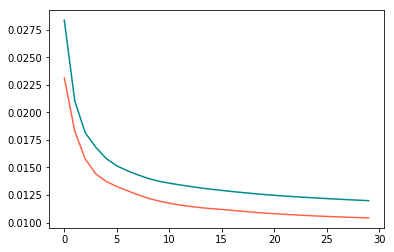

In [26]:
input_size=13
hidden_size=24
num_layers=2
lstm=LSTM(input_size,hidden_size)

learning_rate=0.001
max_grad_norm=5
loss_fn = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=0.00001)

batch_size = 8
num_epochs = 30 #3
# num_sequences = x_train_set.size(0)
# num_batches = num_sequences //batch_size

checkpoint_freq = 10
path = './'

train_losses=[]
valid_losses=[]

print("Training model for {} epoch".format(num_epochs))
for epoch in range(num_epochs):
#     total_loss = 0

    # Shuffle input and target sequences.
    idx = torch.randperm(x_train_set.size(0))
    x = x_train_set[idx]
    y = y_train_set[idx]
    
    train_loss=train(lstm,x_train_set,y_train_set,optimizer,batch_size,epoch)
    valid_loss=eval(lstm,x_valid_set,y_valid_set,optimizer,batch_size)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, lstm, path)
        
# Last checkpoint
save_model(num_epochs, lstm, path)
    
print("\n\n\nOptimization ended.\n")

plt.plot(train_losses, color="darkcyan", label="train")
plt.plot(valid_losses, color="tomato",label="validation")
plt.show()

In [27]:
def predict_one_hour(model,x_valid_set,input_size,num_steps,scaler):
    predictions=torch.zeros(num_steps)
    for i, x in enumerate(x_valid_set):
        hidden=model.init_hidden(1)
        y_pred,_,_=model(x.contiguous().view(-1, 1, input_size),hidden)
#         print(y_pred.shape)
        predictions[i]=torch.FloatTensor(scaler.inverse_transform(y_pred[0].data)[:,-1])
    return predictions

In [28]:
one_step_predictions = predict_one_hour(lstm, x_test_set, input_size, y_test_set.size(0),scaler)

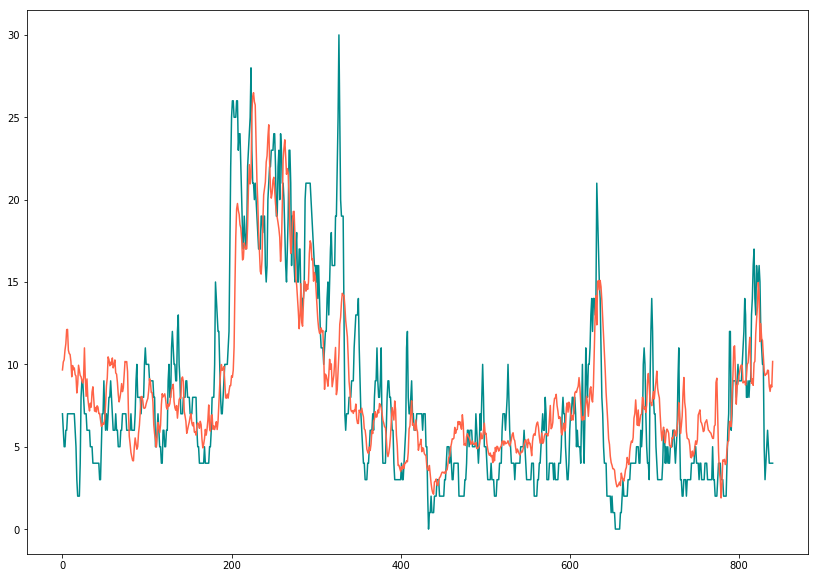

11.944602


In [31]:
fig = plt.figure(figsize=(14, 10))
plt.plot(y_test_set[:,0,-1].data.numpy(),color='darkcyan')
plt.plot(one_step_predictions.data.numpy(),color='tomato')
plt.show()
loss_fn=nn.MSELoss()
print(loss_fn(one_step_predictions,y_test_set[:,0,-1]).data.numpy())